In [1]:
# Importing working libraries
import os
import cv2
import json
import shutil
import math as m
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import describe
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select your development environment
environment = "Local" # "Google Colab", "Local"

# Loading depending on environment
project_path = ""
if environment == "Google Colab":
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  # Import from my google drive
  drive.mount('/content/drive')
  project_path = "/content/drive/MyDrive/GitHub/Cardiovascular-Disease-Prediction"
else:
  project_path = "./"

In [42]:
# Main directory name
dataset_directory = os.path.join(project_path, "dataset")

# List of subdirectories to create
subdirectories = ["original_dataset", "test", "train"]

# Create the main directory if it doesn't exist
os.makedirs(dataset_directory, exist_ok=True)

# Create subdirectories inside the main directory
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(dataset_directory, subdirectory)
    os.makedirs(subdirectory_path, exist_ok=True)
    print(f"Directory created: {subdirectory_path}")

# Rename the file "cardio_train.csv" to "original_dataset.csv"
original_file_path = os.path.join(dataset_directory, "cardio_train.csv")
new_file_path = os.path.join(dataset_directory, "dataset.csv")
os.rename(original_file_path, new_file_path)
print(f"File renamed successfully")

# Moving the original dataset
source_path = os.path.join(dataset_directory, "dataset.csv")
destination_path = os.path.join(dataset_directory, "original_dataset", "dataset.csv")
shutil.move(source_path, destination_path)
print(f'The file {source_path} has been moved to {destination_path}')

Directory created: /content/drive/MyDrive/GitHub/Cardiovascular-Disease-Prediction/dataset/original_dataset
Directory created: /content/drive/MyDrive/GitHub/Cardiovascular-Disease-Prediction/dataset/test
Directory created: /content/drive/MyDrive/GitHub/Cardiovascular-Disease-Prediction/dataset/train
File renamed successfully
The file /content/drive/MyDrive/GitHub/Cardiovascular-Disease-Prediction/dataset/dataset.csv has been moved to /content/drive/MyDrive/GitHub/Cardiovascular-Disease-Prediction/dataset/original_dataset/dataset.csv


In [43]:
# Load the training data
path_dataset = os.path.join(project_path, "dataset/original_dataset/dataset.csv")
dataset = pd.read_csv(path_dataset, delimiter=';')

# Convert each column into a NumPy array
age = np.array(dataset['age'])
gender = np.array(dataset['gender'])
height = np.array(dataset['height'])
weight = np.array(dataset['weight'])
ap_hi = np.array(dataset['ap_hi'])
ap_lo = np.array(dataset['ap_lo'])
cholesterol = np.array(dataset['cholesterol'])
gluc = np.array(dataset['gluc'])
smoke = np.array(dataset['smoke'])
alco = np.array(dataset['alco'])
active = np.array(dataset['active'])
cardio = np.array(dataset['cardio'])

# Sort by category
numerical_features = {"age":age,"height":height,"weight":weight,"ap_hi":ap_hi,"ap_lo":ap_lo}
categorical_features = {"gender":gender,"cholesterol":cholesterol,"gluc":gluc,"smoke":smoke,"alco":alco,"active":active,"cardio":cardio}

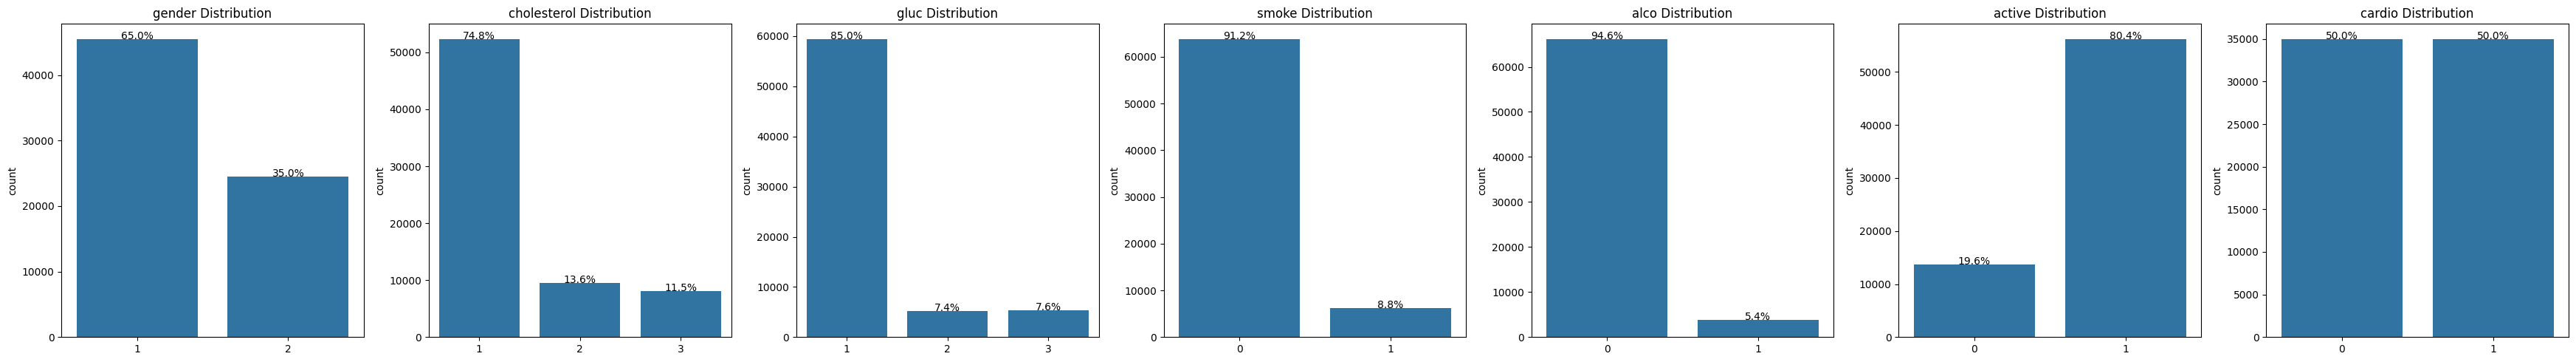

In [44]:
# Let's look at the categorical features

# Calculate the number of subplots needed
num_plots = len(categorical_features)

# Set up subplots in a single row
fig, axes = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

# Iterate through categorical features
for i, (key, value) in enumerate(categorical_features.items()):
    # Use the subplot corresponding to the current iteration
    plt.subplot(1, num_plots, i + 1)

    # Create a countplot
    sns.countplot(x=value)

    # Add percentage labels on top of each bar
    total = len(value)
    for p in axes[i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.05
        axes[i].annotate(percentage, (x, y), ha='center')

    # Set plot title
    plt.title(f'{key} Distribution')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

---

Nothing special to report. We note that the distribution of sick and healthy patients is balanced.

---

In [45]:
# Create a DataFrame
df = pd.DataFrame({
    'gender': gender,
    'cardio': cardio
})

# Count the number of individuals for each combination of gender and cardio
count_combinations = df.groupby(['gender', 'cardio']).size().reset_index(name='count')

# Sum of the 'count' column
total_count = count_combinations['count'].sum()

# Calculate the total count for each gender
total_gender_count = df.groupby('gender').size().reset_index(name='total_count_gender')

# Merge the two DataFrames on the 'gender' column
count_combinations = pd.merge(count_combinations, total_gender_count, on='gender')

# Add a 'proportion' column
count_combinations['proportion'] = count_combinations['count'] / count_combinations['total_count_gender']

# Display the result
print(count_combinations)

   gender  cardio  count  total_count_gender  proportion
0       1       0  22914               45530    0.503273
1       1       1  22616               45530    0.496727
2       2       0  12107               24470    0.494769
3       2       1  12363               24470    0.505231


---

Looking in more detail, we see that this equity of distribution (sick and healthy patients) is equally respected for both sexes.

---

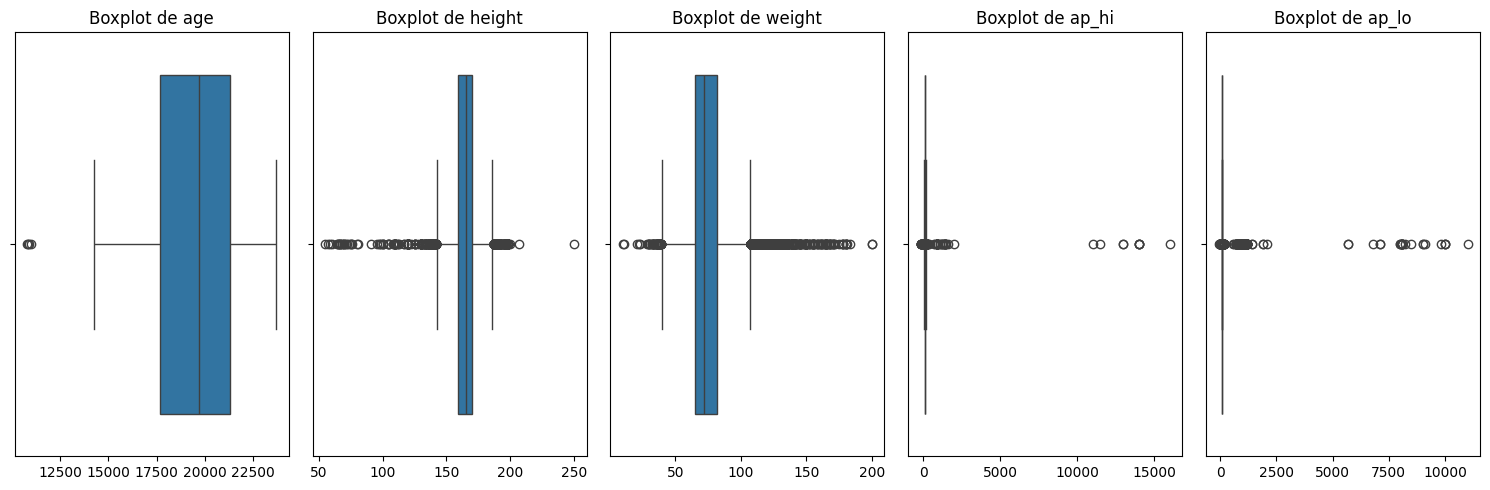

In [46]:
# Let's look at the numerical features

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

# Let's look at the numerical features
for i, (key, value) in enumerate(numerical_features.items()):
    # Use the subplot corresponding to the current iteration
    plt.subplot(1, 5, i + 1)

    # Create boxplot
    sns.boxplot(x=value)

    # Set title
    plt.title(f'Boxplot de {key}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

----

A very large number of outliers are observed in particular for ap_hi and ap_lo.

As part of a Machine Learning project, we will often choose to delete an outlier. Indeed, to obtain better prediction quality it is necessary to process this data because a model could be very sensitive to extreme data which will bias the predictions.

This is what we are going to do but the question is to know what data to delete, that is to say knowing when this data is aberrant or not in our case.

To do this, let's study the different statistical data of our features a little more closely.

----

In [47]:
# Analyzing the distribution of numerical features

def remove_outliers(feature, weight=1.5):
    # Calculate the first and third quartiles
    Q1 = np.percentile(feature, 25)
    Q3 = np.percentile(feature, 75)
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    # Define the lower and upper bounds to consider values as non-outliers
    lower_bound = Q1 - weight * IQR
    upper_bound = Q3 + weight * IQR
    # Filter out outlier values
    filtered_feature = feature[(feature >= lower_bound) & (feature <= upper_bound)]
    return filtered_feature, lower_bound, upper_bound

def feature_analysis(feature):
  # --- Calculations ---
  min_val = np.min(feature)
  D1 = np.percentile(feature, 10)
  Q1 = np.percentile(feature, 25)
  median = np.percentile(feature, 50)
  mean = round(np.mean(feature), 2)
  std = round(np.std(feature), 2)
  Q3 = np.percentile(feature, 75)
  D9 = np.percentile(feature, 90)
  max_val = np.max(feature)
  # ---
  feature_size = len(feature)
  weights = [1.5, 2, 3, 4, 5, 6]
  deletion_data = []
  for weight in weights:
    filtered_feature, lower_bound, upper_bound = remove_outliers(feature, weight)
    filtered_feature_size = len(filtered_feature)
    number_individuals_deleted = feature_size - filtered_feature_size
    removal_percentage = round((number_individuals_deleted / feature_size) * 100, 2)
    deletion_data.append([number_individuals_deleted, removal_percentage, lower_bound, upper_bound])
  # --- Display ---
  print("--------------------------------")
  print("--- ", key, " ---")
  print("---")
  print("Min : ", min_val)
  print("D1 : ", D1)
  print("Q1 : ", Q1)
  print("Median : ", median)
  print("Mean : ", mean)
  print("Standard deviation : ", std)
  print("Q3 : ", Q3)
  print("D9 : ", D9)
  print("Max : ", max_val)
  print("---")
  print("Analysis of the impact of feature filtering based on weight")
  print("Feature size : ", feature_size)
  for i in range(len(weights)):
    print(f"Weight {weights[i]} : Removal percentage = {deletion_data[i][1]}% ({deletion_data[i][0]} deletions), Bound = [{deletion_data[i][2]},{deletion_data[i][3]}]")

# Data analysis
for key, value in numerical_features.items():
  feature_analysis(value)


--------------------------------
---  age  ---
---
Min :  10798
D1 :  15840.0
Q1 :  17664.0
Median :  19703.0
Mean :  19468.87
Standard deviation :  2467.23
Q3 :  21327.0
D9 :  22639.0
Max :  23713
---
Analysis of the impact of feature filtering based on weight
Feature size :  70000
Weight 1.5 : Removal percentage = 0.01% (4 deletions), Bound = [12169.5,26821.5]
Weight 2 : Removal percentage = 0.0% (0 deletions), Bound = [10338.0,28653.0]
Weight 3 : Removal percentage = 0.0% (0 deletions), Bound = [6675.0,32316.0]
Weight 4 : Removal percentage = 0.0% (0 deletions), Bound = [3012.0,35979.0]
Weight 5 : Removal percentage = 0.0% (0 deletions), Bound = [-651.0,39642.0]
Weight 6 : Removal percentage = 0.0% (0 deletions), Bound = [-4314.0,43305.0]
--------------------------------
---  height  ---
---
Min :  55
D1 :  155.0
Q1 :  159.0
Median :  165.0
Mean :  164.36
Standard deviation :  8.21
Q3 :  170.0
D9 :  175.0
Max :  250
---
Analysis of the impact of feature filtering based on weight
Fea

---

As we can observe, both ap_hi (Systolic blood pressure) and particularly ap_lo (Diastolic blood pressure) have a large number of outlier values, raising the question of which variables are truly outliers. To address this issue, we sought official data to get an idea of the possible ranges of variation. Below, you can see a summary table of blood pressure values.

Source : MedicineNet - https://www.medicinenet.com/blood_pressure_chart_reading_by_age/article.htm

---

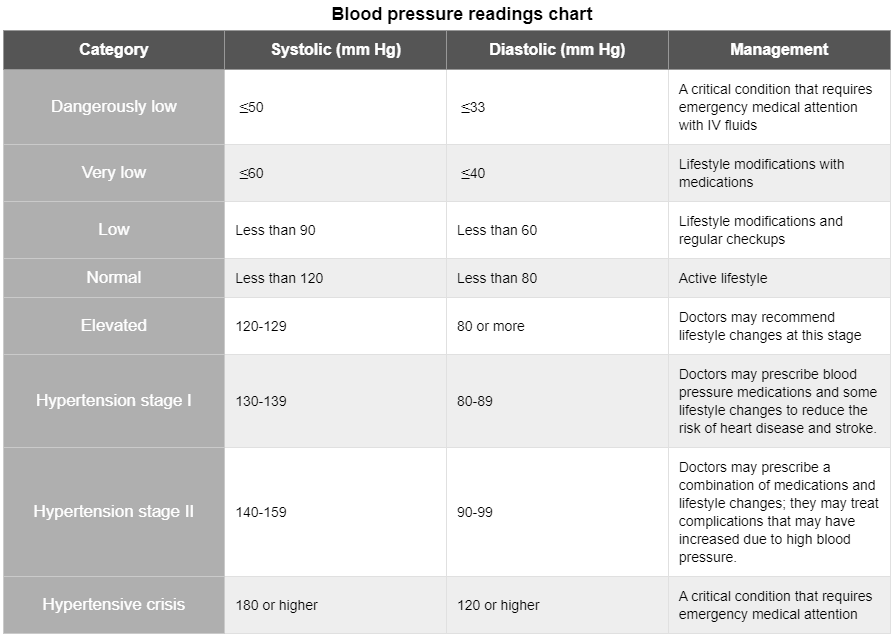

---

We will now define lower and upper bounds for all our variables to select training data that describes a humanly and biologically possible reality.

As for blood pressure data, it cannot be negative, so that will be the lower bound. Regarding the upper bound, after some research, the Emergency Medicine (American Journal) reports record cases of blood pressure up to 370 mm Hg, so that will be our upper bound.

---

In [48]:
# Definition of lower and upper limits
bound_age = [0,44694] # [must be positive, Jeanne Calment]
bound_height = [0,272] # [must be positive, Robert Wadlow]
bound_weight = [0,635] # [must be positive, Jon Brower Minnoch]
bound_ap_hi = [0,370] # [must be positive, extreme case reported by Emergency Medicine]
bound_ap_lo = [0,370] # [must be positive, extreme case reported by Emergency Medicine]

bounds = {"age":bound_age,"height":bound_height,"weight":bound_weight,"ap_hi":bound_ap_hi,"ap_lo":bound_ap_lo}

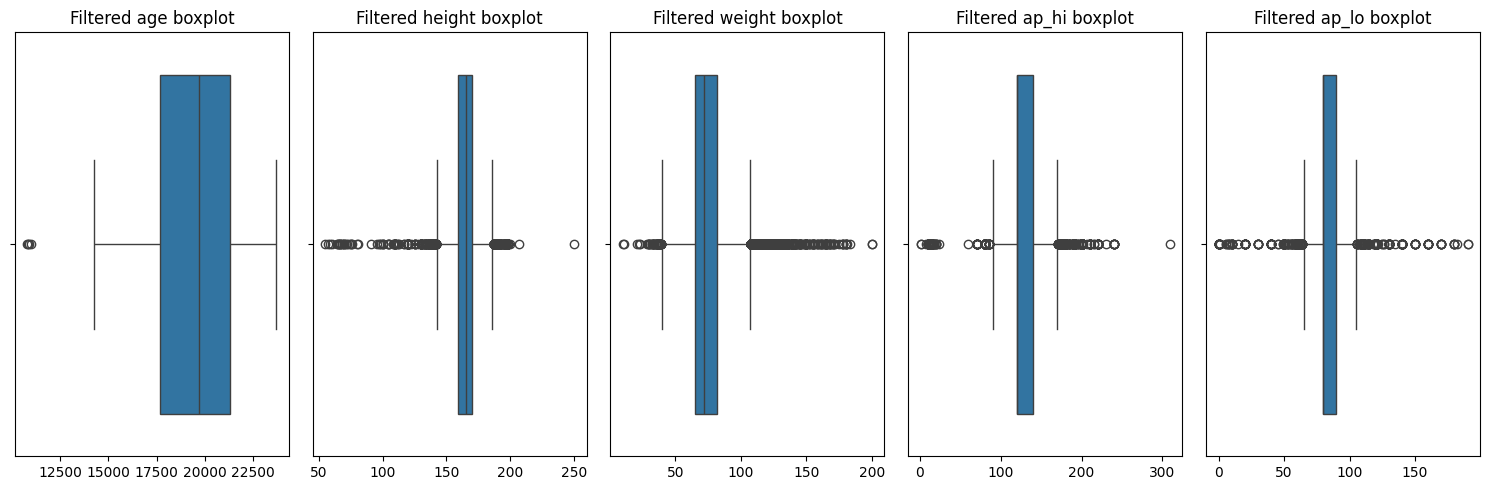

In [49]:
# Displaying the new boxplots

def remove_outliers_outside_range(feature,lower_bound,upper_bound):
  filtered_feature = feature[(feature >= lower_bound) & (feature <= upper_bound)]
  return(filtered_feature)

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

# Displaying the new boxplots
for i, (key, value) in enumerate(numerical_features.items()):
    # Remove outliers and update numerical_features
    filtered_value = remove_outliers_outside_range(value, bounds[key][0], bounds[key][1])
    numerical_features[key] = filtered_value

    # Use the subplot corresponding to the current iteration
    plt.subplot(1, 5, i + 1)

    # Create boxplot
    sns.boxplot(x=filtered_value)

    # Set title
    plt.title(f'Filtered {key} boxplot')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

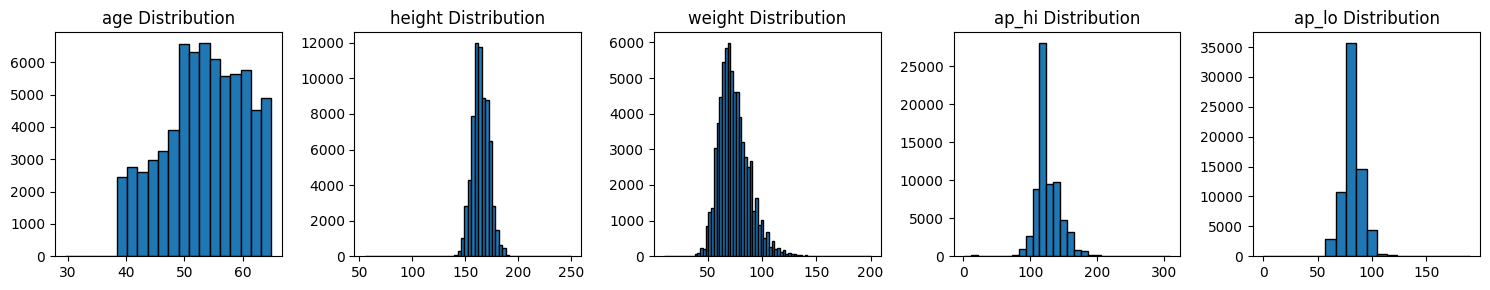

In [50]:
# Let's look at the histogram of numerical features

bins_size = {"age": 20, "height": 60, "weight": 75, "ap_hi": 30, "ap_lo": 20}

# Set up a 1x5 grid for subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Histogram of numerical features
for i, (key, value) in enumerate(numerical_features.items()):
    if key == "age":
        axs[i].hist(value/365.25, bins=bins_size[key], edgecolor='black')
    else:
        axs[i].hist(value, bins=bins_size[key], edgecolor='black')
    axs[i].set_title(f'{key} Distribution')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

---

We have just removed the a priori impossible outlier values, which were likely associated with information collection errors. It remains to be determined whether we want to sort the extreme but semantically plausible values. For now, we will limit ourselves to the sorting we have already performed.

We will now create two datasets (train and test) to split the original dataset into a training set and a test set. Then, we will create a new training dataset corresponding to the training dataset with the removed outlier values.

---

In [51]:
# Separate the original dataset into train and test sets

# Path to CSV files
dataset_path = os.path.join(project_path, "dataset/original_dataset/dataset.csv")
train_path = os.path.join(project_path, "dataset/train/train_original.csv")
test_path = os.path.join(project_path, "dataset/test/test_original.csv")

# Load the dataset from the CSV file
dataset = pd.read_csv(dataset_path)

# Split the dataset into training and test sets (80% - 20%)
training_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Save them to CSV files
training_set.to_csv(train_path, index=False)
test_set.to_csv(test_path, index=False)

In [52]:
# Path to the CSV file
path_train = os.path.join(project_path, "dataset/train/train_original.csv")

# Load the dataset specifying the delimiter
df = pd.read_csv(path_train, delimiter=';')

# Filter out outliers
for feature, (lower_bound, upper_bound) in bounds.items():
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Specify the name of the new dataset
path_new_train = os.path.join(project_path, "dataset/train/train_without_impossible_values.csv")

# Save the new dataset
df.to_csv(path_new_train, index=False)

In [53]:
# Observe how many individuals were deleted
train_path = os.path.join(project_path, "dataset/train/train_original.csv")
path_new_train = os.path.join(project_path, "dataset/train/train_without_impossible_values.csv")

train = pd.read_csv(train_path, delimiter=';')
new_train = pd.read_csv(path_new_train, delimiter=',')

print(f"Number of individuals deleted: {len(train)-len(new_train)} -> {round(((len(train)-len(new_train))/len(train))*100,2)}% of the original training dataset")

Number of individuals deleted: 801 -> 1.43% of the original training dataset


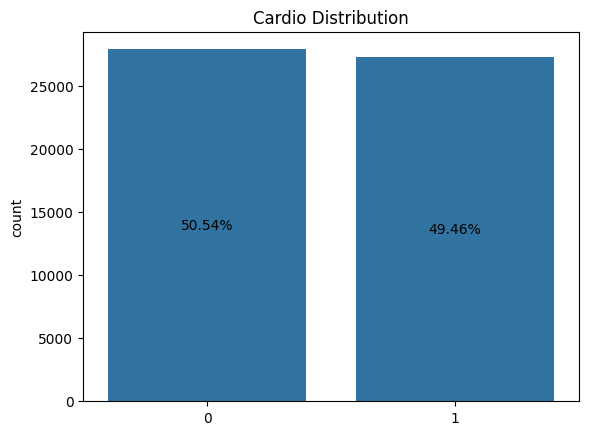

In [54]:
# Let's check that there are still as many sick people as healthy people

# Create a numpy array from 'cardio' column
cardio = np.array(new_train['cardio'])

# Plot the countplot
ax = sns.countplot(x=cardio)

# Set the title
plt.title('Cardio Distribution')

# Calculate the percentage for each bar
total_count = len(cardio)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2, height / 2, f'{percentage:.2f}%', ha='center', va='center')

# Show the plot
plt.show()

---

Let's perform a PCA to see if we can reduce the size of our data.

---

In [55]:
def PCA_display(X):
    # Standardize the data before PCA
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_standardized)

    # Retrieve explained variance for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Display the histogram of explained variance
    axs[0].bar(range(1, len(explained_variance) + 1), explained_variance, color='b', alpha=0.7)
    axs[0].set_title('Explained Variance for Each Principal Component')
    axs[0].set_xlabel('Principal Component')
    axs[0].set_ylabel('Explained Variance')
    axs[0].set_xticks(range(1, len(explained_variance) + 1))
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Calculate cumulative explained variance
    cumulative_variance = explained_variance.cumsum()

    # Display the cumulative explained variance plot
    axs[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    axs[1].set_title('Cumulative Explained Variance')
    axs[1].set_xlabel('Number of Principal Components')
    axs[1].set_ylabel('Cumulative Explained Variance')
    axs[1].set_xticks(range(1, len(cumulative_variance) + 1))
    axs[1].grid(True)

    # Adjust layout to prevent clipping of titles and labels
    plt.tight_layout()

    # Show the plots
    plt.show()

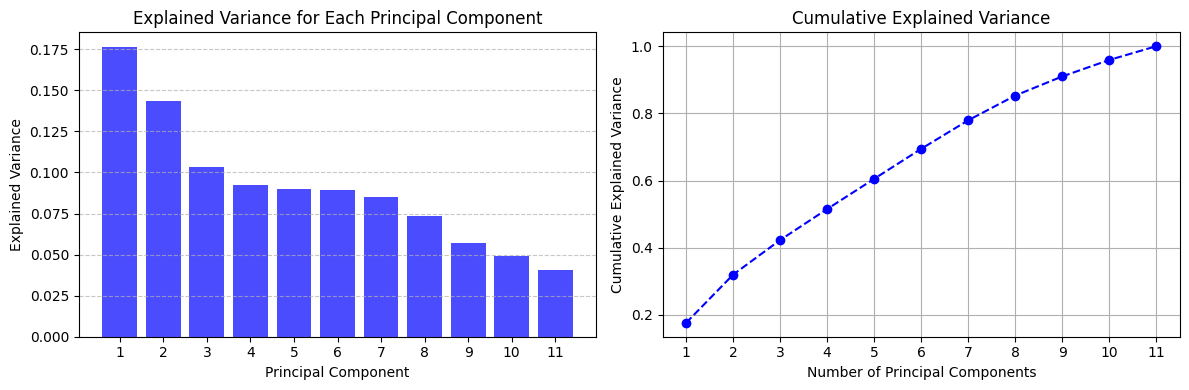

In [56]:
# Definition of paths
path_dataset = os.path.join(project_path, "dataset/original_dataset/dataset.csv")

# Loading datasets
dataset = pd.read_csv(path_dataset, delimiter=';')

# Separate features and the target variable
X_dataset = dataset.drop('cardio', axis=1).drop('id', axis=1)

# PCA Display
PCA_display(X_dataset)

---

We observe that there is no interest in performing PCA on our data since the variance explained by each axis is very low.

---

Finally, we will create a second training set consisting of “train without impossible values.csv” data but removing plausible but extreme values.

---

In [57]:
# Path to the CSV file
path_train = os.path.join(project_path, "dataset/train/train_without_impossible_values.csv")

# Load the dataset specifying the delimiter
df = pd.read_csv(path_train, delimiter=',')

# Calculate bounds using IQR method
def calculate_bounds(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return lower_bound, upper_bound

# Calculate bounds for each feature
bounds = {
    'age': calculate_bounds(df['age']),
    'height': calculate_bounds(df['height']),
    'weight': calculate_bounds(df['weight']),
    'ap_hi': calculate_bounds(df['ap_hi']),
    'ap_lo': calculate_bounds(df['ap_lo'])
}

# Filter out outliers
for feature, (lower_bound, upper_bound) in bounds.items():
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Specify the name of the new dataset
path_new_train = os.path.join(project_path, "dataset/train/train_without_extreme_values.csv")

# Save the new dataset
df.to_csv(path_new_train, index=False)

In [58]:
# Observe how many individuals were deleted
train_path = os.path.join(project_path, "dataset/train/train_original.csv")
path_new_train = os.path.join(project_path, "dataset/train/train_without_extreme_values.csv")

train = pd.read_csv(train_path, delimiter=',')
new_train = pd.read_csv(path_new_train, delimiter=',')

print(f"Number of individuals deleted: {len(train)-len(new_train)} -> {round(((len(train)-len(new_train))/len(train))*100,2)}% of the original training dataset")

Number of individuals deleted: 5987 -> 10.69% of the original training dataset


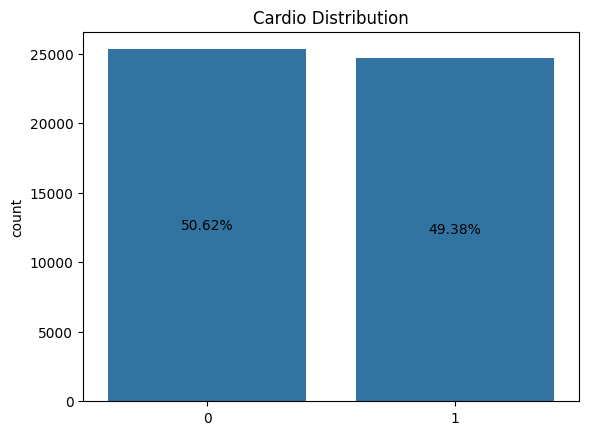

In [59]:
# Let's check that there are still as many sick people as healthy people

# Create a numpy array from 'cardio' column
cardio = np.array(new_train['cardio'])

# Plot the countplot
ax = sns.countplot(x=cardio)

# Set the title
plt.title('Cardio Distribution')

# Calculate the percentage for each bar
total_count = len(cardio)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2, height / 2, f'{percentage:.2f}%', ha='center', va='center')

# Show the plot
plt.show()

---

We still have equal proportions between sick and healthy individuals, which is really a good thing. Indeed, one could have feared that the outlier values might be too specifically linked to the sick.

---

We will train models on these two different datasets and see which one allows us to achieve the best results.

---